In [1]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np


# **1.1 Getting Correspondences**

In [2]:
# read the images
img1 = cv2.imread('/content/cv_cover.jpg')  
img2 = cv2.imread('/content/im.jpg')
# convert images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()
# detect SIFT features in both images
keypoints_1, descriptors_1 = sift.detectAndCompute(gray1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(gray2,None)

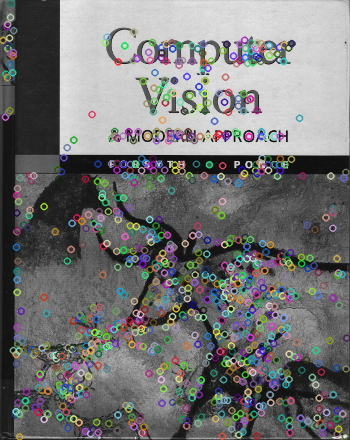

In [3]:
# Marking the keypoint on the image using circles
img = cv2.drawKeypoints(gray1,	keypoints_1, img1.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# draw the detected key points
sift_image = cv2.drawKeypoints(gray1, keypoints_1, img)

# show the image
cv2_imshow(sift_image)

In [4]:
# Brute force matcher
bf = cv2.BFMatcher()

# match descriptors of both images
matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

In [6]:
good = []
for m,n in matches:
    if m.distance < 0.5 * n.distance:
        good.append([m])

In [7]:
# draw first 50 matches
matched_img = cv2.drawMatchesKnn(img1, keypoints_1, img2, keypoints_2, good[:50], img2, flags=2)

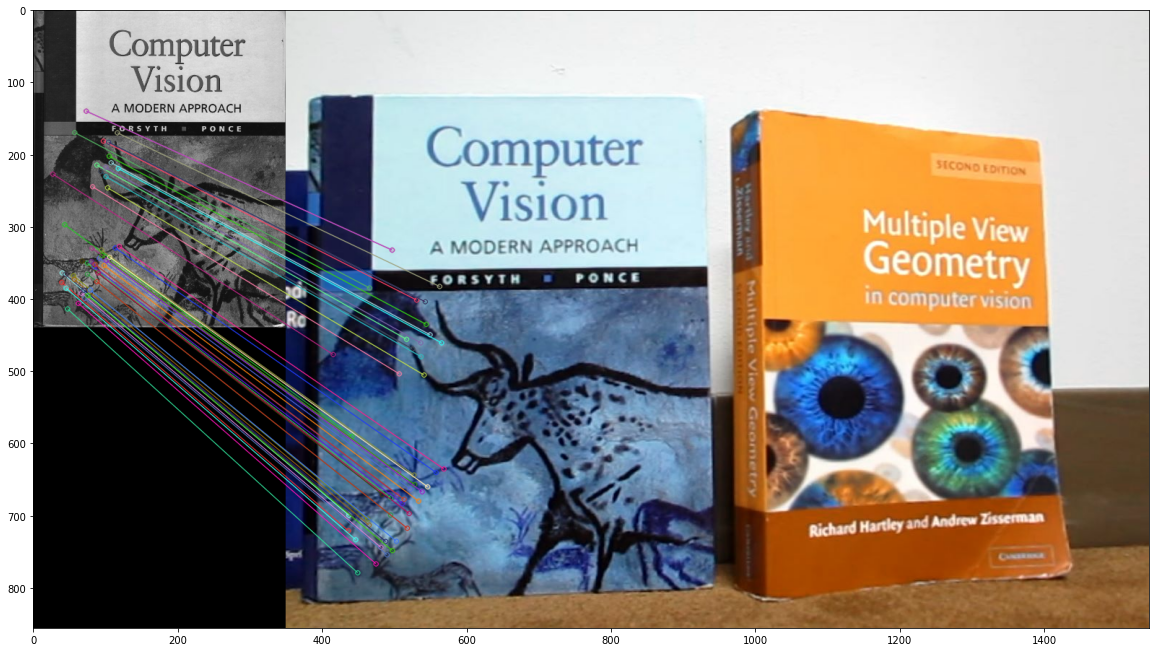

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(matched_img)
plt.show()

# **1.2 Compute the Homography Parameters**

In [9]:
num_pt = 50

In [10]:
pts1 = np.float32([keypoints_1[m[0].queryIdx].pt for m in good[:50]]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints_2[m[0].trainIdx].pt for m in good[:50]]).reshape(-1, 1, 2)

In [11]:
def homograph_mat(pts1, pts2):
  a_mat = np.zeros((pts1.shape[0] * 2, 9))
  ind = 0
  for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
    x = pt1[0][0]
    y = pt1[0][1]
    xd = pt2[0][0]
    yd = pt2[0][1]
    x_xd = x * xd
    y_xd = y * xd
    x_yd = x * yd
    y_yd = y * yd
    a_mat[ind][0], a_mat[ind][1], a_mat[ind][2], a_mat[ind][6], a_mat[ind][7], a_mat[ind][8] = -x, -y, -1, x_xd, y_xd, xd
    a_mat[ind+1][3], a_mat[ind+1][4], a_mat[ind+1][5], a_mat[ind+1][6], a_mat[ind+1][7], a_mat[ind+1][8] = -x, -y, -1, x_yd, y_yd, yd
    ind += 2
  U, D, V = np.linalg.svd(a_mat, full_matrices=False)
  eigenVectors = (V[-1] / V[-1][-1]).reshape((3, 3))
  return eigenVectors

In [15]:
matrix, _ = cv2.findHomography(pts1, pts2) 
matrix

array([[ 1.69705292e+00, -1.61186347e-03,  2.08888987e+01],
       [ 6.78801330e-02,  1.64383334e+00,  1.03951055e+02],
       [ 1.89373414e-04, -2.07959054e-07,  1.00000000e+00]])

In [17]:
matrix =  homograph_mat(pts1, pts2)
matrix

array([[ 1.64313956e+00, -8.04756311e-03,  2.36588341e+01],
       [-1.35494747e-05,  1.58477224e+00,  1.13570511e+02],
       [ 6.99134355e-05, -4.24980459e-05,  1.00000000e+00]])

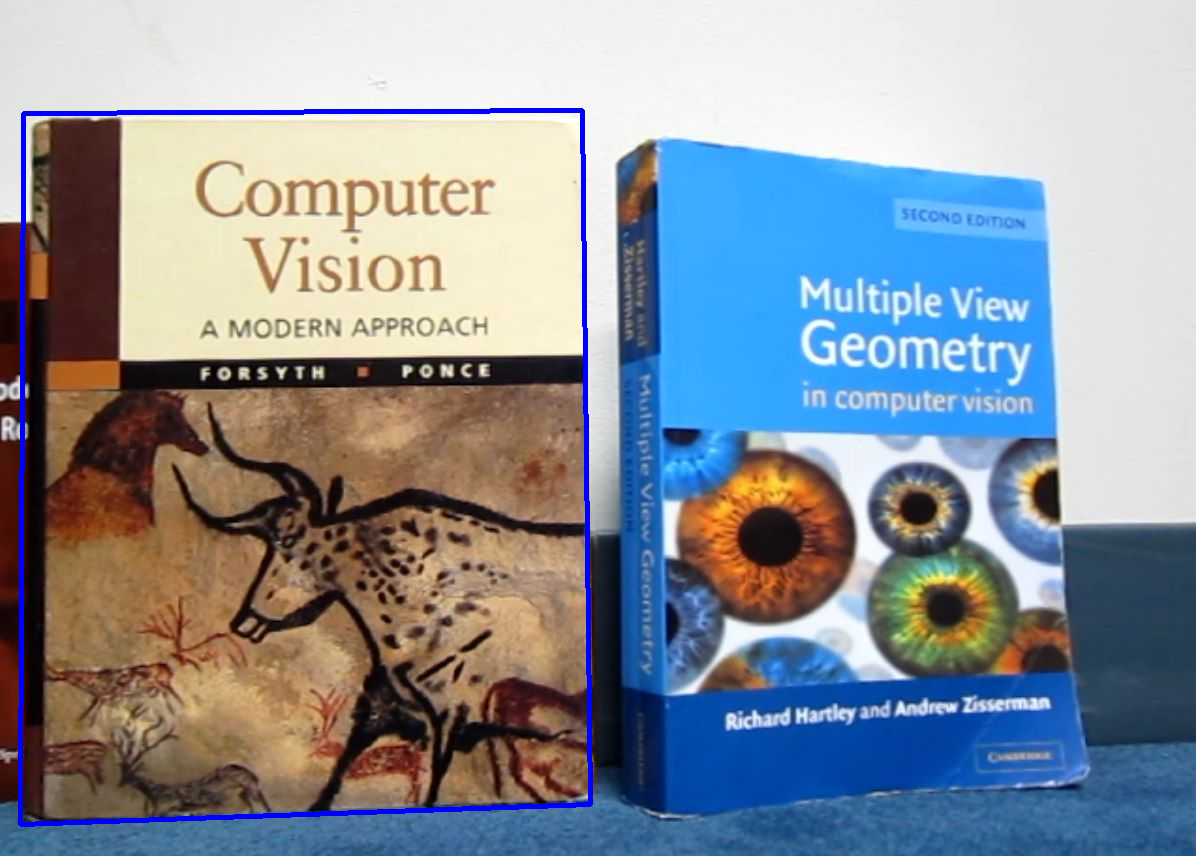

In [18]:
h,w,d = img.shape
pts = np.float32([ [0, 0],[0, h-1],[w-1, h-1],[w-1, 0] ]).reshape(-1,1,2)
 
dst = cv2.perspectiveTransform(pts, matrix)
 
homography = cv2.polylines(img2.copy(), [np.int32(dst)], True, (255, 0, 0), 3) 
 
cv2_imshow(homography) 